In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/subashgandyer/datasets/main/loan_train.csv'

In [3]:
data = pd.read_csv(url)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# DATA PREPROCESSING:

Right of the bat we notice a few issues:

- we need to encode catagorical data
- we need to deal with the NaN values (one found in loan amount)
- get rid of useless features (one we know that irrelevent is 'Loan_ID')
- checking the distribution of data (coapplicantincome looks like trouble)

We will do this by:

- filling NaNs for catagorical feature
- Encoding catagorical features
- At this point all our data should be numerical, so we will scale all the numerical features
- us imputer pipeline to see which imputer yeids best results (mean, median, iterative)

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Missing Data and Encoding

In [6]:
# check percentage of data in each feature that is missing

for col in data.columns:                    
  null_data = np.mean(data[col].isnull())
  print('{} - {}%'.format(col, round(null_data*100)))

Loan_ID - 0%
Gender - 2%
Married - 0%
Dependents - 2%
Education - 0%
Self_Employed - 5%
ApplicantIncome - 0%
CoapplicantIncome - 0%
LoanAmount - 4%
Loan_Amount_Term - 2%
Credit_History - 8%
Property_Area - 0%
Loan_Status - 0%


We can see that there isn't too much data missing. We could just remove the rows with missing data in this case however we wont do that in order to give our model the highest accuracy.

In [7]:
y = data.iloc[:, -1]
y.head()

0    Y
1    N
2    Y
3    Y
4    Y
Name: Loan_Status, dtype: object

In [8]:
data_num = data.iloc[:, 6:11]
data_num.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


In [9]:
data_cat = data.drop(data.columns[[6, 7, 8, 9, 10, 12]], axis = 1)
data_cat.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,LP001002,Male,No,0,Graduate,No,Urban
1,LP001003,Male,Yes,1,Graduate,No,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,Urban
4,LP001008,Male,No,0,Graduate,No,Urban


The first feature in data_cat seem unimportant so we will drop it

In [10]:
data_cat = data_cat.drop(data_cat.columns[[0]], axis = 1)
data_cat.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,No,0,Graduate,No,Urban
1,Male,Yes,1,Graduate,No,Rural
2,Male,Yes,0,Graduate,Yes,Urban
3,Male,Yes,0,Not Graduate,No,Urban
4,Male,No,0,Graduate,No,Urban


### Catagorical Missing Values and Encoding

### Gender:

In [11]:
# How many different values and what percentage

data_cat.Gender.value_counts()/data_cat.shape[0] # unique value count / number of items

Male      0.796417
Female    0.182410
Name: Gender, dtype: float64

We notice that for gender there is only male which makes up 80% of the data and female which makes up 18% of the data. In this case using the mode makes sense when it comes to replacing the missdata in this feature. Due to the fact that there are only 2 unque values in this feature, we can manually force the NaN to turn into the mode, Male.

In [12]:
data_cat['Gender'].fillna('Male', inplace=True)

### Dependents:

In [13]:
# How many different values and what percentage

data_cat.Dependents.value_counts()/data_cat.shape[0] # unique value count / number of items

0     0.561889
1     0.166124
2     0.164495
3+    0.083062
Name: Dependents, dtype: float64

We will first make the dicision that 3 or more dependents can be classified as 3, this way 3+ turns into an integer value. Then we will replace the NaNs with the mode.

In [14]:
data_cat.loc[data_cat['Dependents']  == '3+', 'Dependents'] = 3  # if row is 3+ in 'Dependents', replace row in 'Depenets' with 3
data_cat['Dependents'].fillna('0', inplace=True)
data_cat.Dependents.value_counts()/data_cat.shape[0]

0    0.586319
1    0.166124
2    0.164495
3    0.083062
Name: Dependents, dtype: float64

In [15]:
data_cat["Dependents"] = data_cat["Dependents"].astype('int32')

### Self_Employed:

In [16]:
# How many different values and what percentage

data_cat.Self_Employed.value_counts()/data_cat.shape[0] # unique value count / number of items

No     0.814332
Yes    0.133550
Name: Self_Employed, dtype: float64

In [17]:
# Replace NaNs with mode which is no in this case

data_cat['Self_Employed'].fillna('No', inplace=True)

### Double check if we dealt will all Null values for catagorical features

<AxesSubplot:>

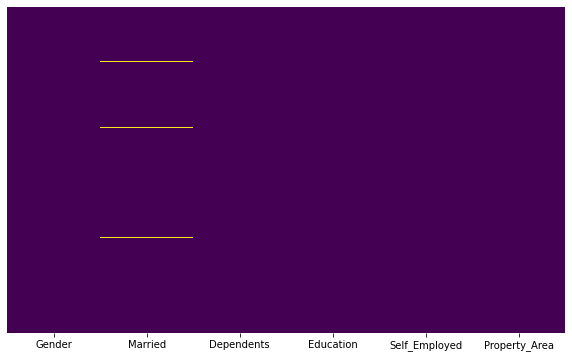

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(data_cat.isna(), cbar=False, cmap='viridis', yticklabels=False)

Even though we checked for nulls before, we seemed to miss one feature

### Married

In [19]:
data_cat.Married.value_counts()/data_cat.shape[0]

Yes    0.648208
No     0.346906
Name: Married, dtype: float64

In [20]:
data_cat['Married'].fillna('Yes', inplace=True)

## Double check Null values in catagorical features

<AxesSubplot:>

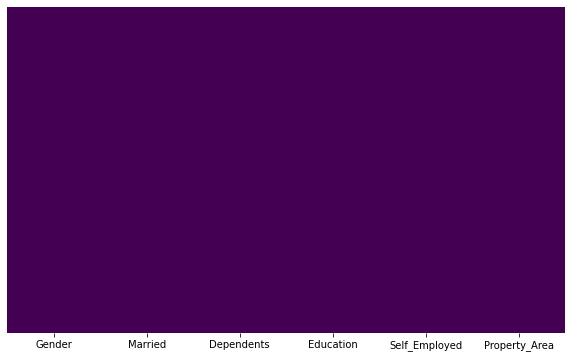

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(data_cat.isna(), cbar=False, cmap='viridis', yticklabels=False)

## Encode data_cat 

In [22]:
# encode the data
le =LabelEncoder()

data_cat["Gender"] = le.fit_transform(data_cat["Gender"])
data_cat["Married"] = le.fit_transform(data_cat["Married"])
data_cat["Education"] = le.fit_transform(data_cat["Education"])
data_cat["Self_Employed"] = le.fit_transform(data_cat["Self_Employed"])
data_cat["Property_Area"] = le.fit_transform(data_cat["Property_Area"])

data_cat.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,1,0,0,0,0,2
1,1,1,1,0,0,0
2,1,1,0,0,1,2
3,1,1,0,1,0,2
4,1,0,0,0,0,2


## Encode y

In [23]:
y_encoded = le.fit_transform(y)
y = pd.DataFrame(data=y_encoded)
y.columns = ['Loan_Status']
y.head()

,Loan_Status
0,1
1,0
2,1
3,1
4,1


## Impute Missing NaNs for data_num

we will use different imputers to see which one is better

In [24]:
def imputer_tester (X, y):
    
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

    from sklearn.impute import SimpleImputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn import svm
    
    lr = LogisticRegression() # Logistic Regression
    rf = RandomForestClassifier() # Random Forest
    KNN = KNeighborsClassifier() # Knn
    SVM = svm.SVC() # SVM

    #results =[] # for model accuracy
    strategies = ['mean', 'median', 'most_frequent','constant']
    model = [lr, rf, KNN, SVM]

    for m in model:
        results =[] # for model accuracy
        print(f"\n{m}:")
        for s in strategies:
            pipeline = Pipeline([('impute', SimpleImputer(strategy=s)),('model', m)])
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
            scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
            results.append(scores)

        pipeline = Pipeline([('impute', IterativeImputer(max_iter=10)), ('model', m)])
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
        scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        strategies.append("iterative") # append 'iterative' so our output table looks nice
        results.append(scores)

        for method, accuracy in zip(strategies, results):
            print(f"Strategy: {method} >> Accuracy: {round(np.mean(accuracy), 3)}   |   Max accuracy: {round(np.max(accuracy), 3)}")

        strategies.pop() # pop "iterative" so the first pipline doesn't run into an issues when calling it's imputer

In [25]:
imputer_tester(data_num, y)


LogisticRegression():
Strategy: mean >> Accuracy: 0.804   |   Max accuracy: 0.871
Strategy: median >> Accuracy: 0.808   |   Max accuracy: 0.855
Strategy: most_frequent >> Accuracy: 0.808   |   Max accuracy: 0.885
Strategy: constant >> Accuracy: 0.762   |   Max accuracy: 0.855
Strategy: iterative >> Accuracy: 0.807   |   Max accuracy: 0.885

RandomForestClassifier():
Strategy: mean >> Accuracy: 0.784   |   Max accuracy: 0.885
Strategy: median >> Accuracy: 0.776   |   Max accuracy: 0.918
Strategy: most_frequent >> Accuracy: 0.781   |   Max accuracy: 0.887
Strategy: constant >> Accuracy: 0.73   |   Max accuracy: 0.855
Strategy: iterative >> Accuracy: 0.781   |   Max accuracy: 0.902

KNeighborsClassifier():
Strategy: mean >> Accuracy: 0.637   |   Max accuracy: 0.71
Strategy: median >> Accuracy: 0.625   |   Max accuracy: 0.705
Strategy: most_frequent >> Accuracy: 0.628   |   Max accuracy: 0.71
Strategy: constant >> Accuracy: 0.622   |   Max accuracy: 0.694
Strategy: iterative >> Accuracy: 

I did this to compare simple(mean, median) and itierative, it seems as tho iterative does the best in general

In [26]:
imputer = IterativeImputer(max_iter=10)
imputer.fit(data_num)
data_num_imputed = imputer.transform(data_num)
data_num = pd.DataFrame(data=data_num_imputed)
data_num.columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

## Double check NaNs in numerical data

<AxesSubplot:>

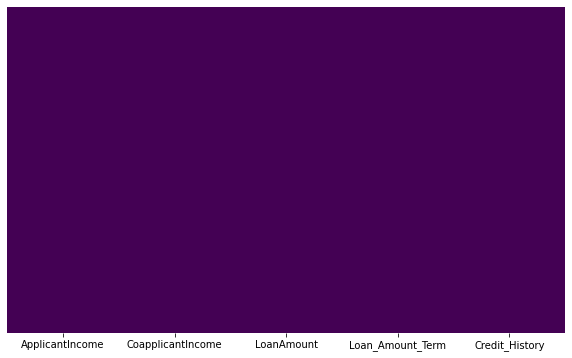

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(data_num.isna(), cbar=False, cmap='viridis', yticklabels=False)

## Feature Scaling

Now that all the data is encoded and does not have any nulls, we will combine the new numerical and catagorical data and then scale the data to normalize the data.

In [28]:
scale = MinMaxScaler()

data_num_scale = scale.fit_transform(data_num)
data_num = pd.DataFrame(data=data_num_scale)
data_num.columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

data_num.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.070489,0.000000,0.186916,0.74359,1.0
1,0.054830,0.036192,0.172214,0.74359,1.0
2,0.035250,0.000000,0.082489,0.74359,1.0
3,0.030093,0.056592,0.160637,0.74359,1.0
4,0.072356,0.000000,0.191027,0.74359,1.0


In [29]:
data = pd.concat([data_cat, data_num], axis=1)
data.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,2,0.070489,0.000000,0.186916,0.74359,1.0
1,1,1,1,0,0,0,0.054830,0.036192,0.172214,0.74359,1.0
2,1,1,0,0,1,2,0.035250,0.000000,0.082489,0.74359,1.0
3,1,1,0,1,0,2,0.030093,0.056592,0.160637,0.74359,1.0
4,1,0,0,0,0,2,0.072356,0.000000,0.191027,0.74359,1.0


## Feature Selection

In [30]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from collections import Counter
import math
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

def autoFeatureSelector(X, y, num_feats, methods=[]):
    
    # Pearson
    def cor_selector(X, y,num_feats):
    
        corr_list = []
        feature_names = X.columns.tolist() # get names of features
    
        for i in feature_names:
            corr = np.corrcoef(X[i], y)[0,1] # get corralation value of feature vs y
            corr_list.append(corr) # store corr value
    
        corr_list = [0 if np.isnan(i) else i for i in corr_list] # replace nan corr value with 0
        cor_feature = X.iloc[:, np.argsort(np.abs(corr_list))[-num_feats:]].columns.tolist() # sort features based on highest corr
        cor_support = [True if i in cor_feature else False for i in feature_names]
    
        return cor_support, cor_feature

    # Chi-Square
    
    def chi_squared_selector(X, y, num_feats):
    
        X_norm = MinMaxScaler().fit_transform(X)
        chi_selector = SelectKBest(chi2, k=num_feats)
        chi_selector.fit(X_norm, y)
        chi_support = chi_selector.get_support()
        chi_feature = X.loc[:, chi_support].columns.tolist()
    
        return chi_support, chi_feature
    
    # RFE
    
    def rfe_selector(X, y, num_feats):
    
        X_norm = MinMaxScaler().fit_transform(X)
        rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
        rfe_selector.fit(X_norm, y)
        rfe_support = rfe_selector.get_support()
        rfe_feature = X.loc[:, rfe_support].columns.tolist()
    
        return rfe_support, rfe_feature
    
    # Log-Reg
    
    def embedded_log_reg_selector(X, y, num_feats):
    
        embedded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
        embedded_lr_selector.fit(X, y)
        embedded_lr_support = embedded_lr_selector.get_support()
        embedded_lr_feature = X.loc[:, embedded_lr_support].columns.tolist()
    
        return embedded_lr_support, embedded_lr_feature
    
    # RF
    
    def embedded_rf_selector(X, y, num_feats):
    
        X_norm = MinMaxScaler().fit_transform(X)
        embedded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
        embedded_rf_selector.fit(X_norm, y)
        embedded_rf_support = embedded_rf_selector.get_support()
        embedded_rf_feature = X.loc[:, embedded_rf_support].columns.tolist()

        return embedded_rf_support, embedded_rf_feature
    
    # LGBM
    
    def embedded_lgbm_selector(X, y, num_feats):

        lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2, reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
        embedded_lgbm_selector = SelectFromModel(lgbc, max_features=num_feats)
        embedded_lgbm_selector.fit(X, y)
        embedded_lgbm_support = embedded_lgbm_selector.get_support()
        embedded_lgbm_feature = X.loc[:, embedded_lgbm_support].columns.tolist()

        return embedded_lgbm_support, embedded_lgbm_feature

    
    if 'pearson' in methods:
        cor_support, cor_feature = cor_selector(X, y,num_feats)
    if 'chi-square' in methods:
        chi_support, chi_feature = chi_squared_selector(X, y,num_feats)
    if 'rfe' in methods:
        rfe_support, rfe_feature = rfe_selector(X, y,num_feats)
    if 'log-reg' in methods:
        embedded_lr_support, embedded_lr_feature = embedded_log_reg_selector(X, y, num_feats)
    if 'rf' in methods:
        embedded_rf_support, embedded_rf_feature = embedded_rf_selector(X, y, num_feats)
    if 'lgbm' in methods:
        embedded_lgbm_support, embedded_lgbm_feature = embedded_lgbm_selector(X, y, num_feats)
    
    
    
    pd.set_option('display.max_rows', None)
    feature_names = X.columns.tolist()
    feature_selection_df = pd.DataFrame({'Feature':feature_names, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embedded_lr_support,
                                        'Random Forest':embedded_rf_support, 'LightGBM':embedded_lgbm_support})
    
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    best_features = feature_selection_df.head(num_feats)

    
    return best_features

In [31]:
best_features = autoFeatureSelector(data, y.iloc[:,-1], num_feats = 11, methods=['pearson', 'chi-square', 'rfe', 'log-reg', 'rf', 'lgbm'])
best_features

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,LoanAmount,True,True,True,True,True,True,6
2,CoapplicantIncome,True,True,True,True,True,True,6
3,Credit_History,True,True,True,True,True,False,5
4,ApplicantIncome,True,True,True,False,True,True,5
5,Married,True,True,True,False,False,True,4
6,Self_Employed,True,True,True,False,False,False,3
7,Property_Area,True,True,True,False,False,False,3
8,Loan_Amount_Term,True,True,True,False,False,False,3
9,Gender,True,True,True,False,False,False,3
10,Education,True,True,True,False,False,False,3


Now is the the part where we would do feature selection, however we don't have a lot of features so I don't plan on taking any out. In a way I guess taking the 'Loan_ID' feature was our feature selection section. If we plan on reducing the dimensions of our data, we can always choose the top 4-5 features presented to us. This method uses statistical functions rather than PCA as this is less of a black box method.

# Modelling

In [32]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingClassifier

In [33]:
# split our data
xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size=0.3)

In [34]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((429, 11), (185, 11), (429, 1), (185, 1))

The models we will use are as follows:

- Decision Tree
- KNN
- Logistic Regression
- SVM
- Random Forest
- Naive Bayes
- SGD

I will choose the top 3 models that preform the best, from there we will use gridsearch to tune our models. With our top 3 models tunned we will use a voting ensemble to combine it into our final model.

In [35]:
dt = DecisionTreeClassifier() #Decision Tree 
KNN = KNeighborsClassifier() # Knn
lr = LogisticRegression() # Logistic Regression
SVM = svm.SVC(random_state=1) # SVM
rf = RandomForestClassifier() # Random Forest
nb = GaussianNB() # Naive Bayes
sgd = SGDClassifier() # Stochastic Gradient Descent

model = [dt, KNN, lr, SVM, rf, nb, sgd]

for m in model:
        #results =[] # for model accuracy
        pipeline = Pipeline([('model', m)])
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
        scores = cross_val_score(pipeline, xtrain, ytrain, scoring='accuracy', cv=cv, n_jobs=-1)
        #results.append(scores)
        print(f'{m}: \nAccuracy = {round(np.mean(scores), 3)}\n')

DecisionTreeClassifier(): 
Accuracy = 0.71

KNeighborsClassifier(): 
Accuracy = 0.766

LogisticRegression(): 
Accuracy = 0.819

SVC(random_state=1): 
Accuracy = 0.82

RandomForestClassifier(): 
Accuracy = 0.804

GaussianNB(): 
Accuracy = 0.796

SGDClassifier(): 
Accuracy = 0.726



We notice that both lr and SVC came in first, rf came in second and nb came in third. We will gridsearch all of these models in order to fine tune them. 

In [36]:
# run grid.get_params().keys() if there's invalid param

param_lr = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 50, 100],'solver': ['liblinear']} 
grid_lr = GridSearchCV(lr, param_lr, refit=True)
grid_lr.fit(xtrain, ytrain.values.ravel())
print(f'lr: \nBest Score: {grid_lr.best_score_}\nBest Params: {grid_lr.best_params_}\n')

param_SVM = {'C':[0.01, 0.1, 1], 'gamma': [1, 0.1, 0.01], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']} 
grid_SVM = GridSearchCV(SVM, param_SVM)
grid_SVM.fit(xtrain, ytrain.values.ravel())
print(f'SVM: \nBest Score: {grid_SVM.best_score_}\nBest Params: {grid_SVM.best_params_}\n')

param_rf = {'n_estimators':[100, 300, 500], 
            'max_features':['auto', 'sqrt'], 
            'max_depth': [5, 10, 25, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]}
grid_rf = GridSearchCV(rf, param_rf)
grid_rf.fit(xtrain, ytrain.values.ravel())
print(f'rf: \nBest Score: {grid_rf.best_score_}\nBest Params: {grid_rf.best_params_}\n')

param_nb = {'var_smoothing': np.logspace(0,-9, num=25)} # 25 values btw 0 to -9
grid_nb = GridSearchCV(nb, param_nb)
grid_nb.fit(xtrain, ytrain.values.ravel())
print(f'nb: \nBest Score: {grid_nb.best_score_}\nBest Params: {grid_nb.best_params_}\n')

lr: 
Best Score: 0.8206019151846785
Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

SVM: 
Best Score: 0.8206019151846785
Best Params: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

rf: 
Best Score: 0.8229274965800274
Best Params: {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

nb: 
Best Score: 0.8206019151846785
Best Params: {'var_smoothing': 0.1778279410038923}



In [37]:
# Build our new best models

best_lr = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear').fit(xtrain, ytrain.values.ravel())

best_SVM = svm.SVC(C = 0.1, gamma = 1, kernel = 'linear').fit(xtrain, ytrain.values.ravel())

best_rf = RandomForestClassifier(bootstrap = True, max_depth = 5, max_features = 'sqrt', min_samples_leaf = 2, 
                                 min_samples_split = 5, n_estimators = 100).fit(xtrain, ytrain.values.ravel())

best_nb = GaussianNB(var_smoothing = 0.1778279410038923).fit(xtrain, ytrain.values.ravel())

### Implement Voting Ensemble

In [38]:
voting_model = VotingClassifier(estimators = [('logreg', best_lr), ("SVM", best_SVM),
                                             ("rf", best_rf), ("nb", best_nb)], voting = 'hard')

voting_model.fit(xtrain, ytrain.values.ravel())

voting_score = voting_model.score(xtest, ytest.values.ravel())

print('Voting model score: {}'.format(round(voting_score, 5)))

Voting model score: 0.78378


## Conclusion

It seems that the voting ensemble didn't do as good as the individual models. I think it's important to note that when I didn't enforce random state, the voting model did better than the individual models. All the models had an accuracy of about 82% and the voting model had an accuracy of about 78%. I think this is due to potentually forcing bad splits however the K-Folds should have dealt with that. While I'm not to sure what caused the inconsistance, I will choosing the voting model to be the final model.

After getting ride of all the random states, you can see that the voting model is back to a 78% accuracy. If I had more time I'd look into this, see if using ypred on models when chosing the top 4 models would lead to overfitting and how to automate building a new modeling using best params from grid search. Using best_model = grid_model_params.fit didn't seem to work for me in this case.

In [39]:
final_model = voting_model

final_model_score = final_model.score(xtest, ytest.values.ravel())

print('Final model score: {}'.format(round(final_model_score, 5)))

Final model score: 0.78378
